# Однофазное одномерное течение

In [352]:
# import moudles
# and using magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlinear')
sys.path.append('./partion')
sys.path.append('./probs')

data_path = './data/'

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import one_phase, m1, m2, m3
from fixbd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

import wrapper as wp
test = wp.test_decorator(wp.test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Зададим нелинейную модель

In [259]:
# model to be studied
def model(u):
    return np.array([u**4+1, 4*max(u**3, 0), 12*u**2])

class Diffusion():
    # simple initializer that set
    # sin-amplified permeability coeficents
    def __init__(self, Nx, Amp=0, Period=0, Scale=0.5, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model
    def gen_val(self, Nx, Amp = 0.5, Scale = 0.5, k_sin = 3 , plot = False):
        self.val =  Scale*np.ones((Nx+1, 1))
        x = np.linspace(0, 1, Nx+1).reshape(-1, 1)
        for i in range(1 , k_sin+1):
            self.val *= (1-Amp*np.sin(np.pi*i*x))
            
        if plot:
            plt.title('k(x)')
            plt.plot(x, self.val);
            plt.xlabel('x');
            plt.ylabel('k');

In [260]:
# parameters that we will use
Nx = 2000
Nt = 5
param ={'Nx': Nx, 'Nt' : Nt}

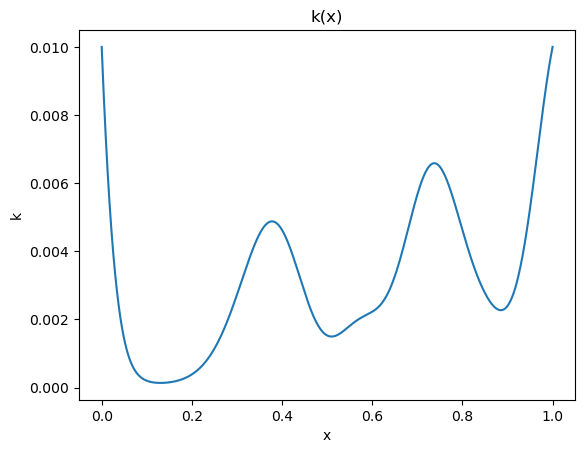

In [261]:
# generate some k(x) to test on latter
D = Diffusion(Nx, 0.9, 1, 2e-2, model=model)
D.gen_val(Nx, Amp = 0.7, Scale = 1e-2, k_sin = 5,  plot = True)
plt.savefig(data_path+'permeability dist, 1', dpi = 400)
plt.show()

### Найдем константы дял базовых операций
Это пригодится нам позднее для задания метрики эффективности солвера на отдельном шаге

In [262]:
Nt = 1

t_res = np.zeros((10, 4))
t_jac = np.zeros((10, 4))
t_lin = np.zeros((10, 4))

for i in range(0, 10):
    Nx = 1000 +i*1000
    param ={'Nx': Nx, 'Nt' : Nt}
    # set initial condition
    x = np.linspace(0, 1, Nx)
    x0 = np.exp(-x)*np.sin(2*np.pi/2*x)**2
    D = Diffusion(Nx, 0.9, 1, 2e-2, model=model)
    D.gen_val(Nx, Amp = 0.2, Scale = 2e-2)
    bd1 = x0[0]
    bd2 = x0[-1]
    
    prob = one_phase(D, param)
    solver_n = fxbd_1D(param, prob)
    solver_n.setBoundary(bd1, bd2)
    solver_n.setSources(s_pos, s_val)
    nl_solver = newton(crit_abs=1e-6)
    solver_n.setSolver(nl_solver)
    solver_n.setInitial(x0)
    
    for j in range(4):
        solver_n.init_log()
        _, mes = solver_n.solve(tmax=1)
        sum_k = np.sum(solver_n.timelog.kn)
        t_res[i, j] = solver_n.timelog.res/((sum_k+1)*10)
        t_jac[i, j] = solver_n.timelog.jac/((sum_k)*10)
        t_lin[i, j] = solver_n.timelog.lin/((sum_k)*10)
        
    print(Nx, np.mean(t_res[i, :]), np.mean(t_jac[i, :]), np.mean(t_lin[i, :]), mes)

1000 0.004641612086977278 0.0036642422278722127 4.677275816599528e-05 OK
2000 0.008975038358143398 0.00833347737789154 9.24984614054362e-05 OK
3000 0.014740759985787527 0.014033889770507813 0.00014764368534088133 OK
4000 0.01737016694886344 0.019432902336120605 0.00016311506430308025 OK
5000 0.02118451935904367 0.025158293048540753 0.00019578138987223306 OK
6000 0.026472435678754534 0.03476227323214213 0.0002579450607299805 OK
7000 0.03052399924823216 0.042380472024281815 0.00027078787485758463 OK
8000 0.03460349355425153 0.052013678352038066 0.00031298100948333745 OK
9000 0.03852519733565194 0.061074103911717734 0.0003583769003550212 OK
10000 0.04398436290877206 0.07972099681695304 0.000421440601348877 OK


[4.30955813e-06] [[3.6933165e-08]]
[7.11829468e-06] [[3.32288611e-07]]
[3.97220446e-08] [[7.48418612e-10]]


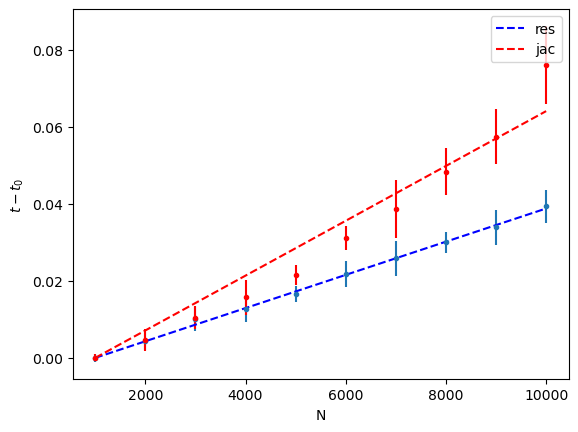

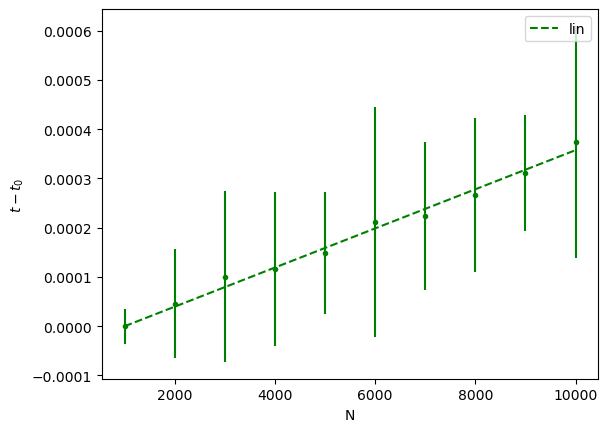

In [263]:
Nx = np.arange(1000, 1000+9*1000+1, 1000)

from scipy.optimize import curve_fit
def func(x, a):
    return x*a

plt.ylabel('$t-t_0$')
plt.xlabel('N')
plt.errorbar(Nx, np.mean(t_res, axis=1)-np.mean(t_res, axis=1)[0],yerr= np.sqrt(np.std(t_res, axis=1))/10, marker='.', linestyle='')
plt.errorbar(Nx, np.mean(t_jac, axis=1)-np.mean(t_jac, axis=1)[0],yerr= np.sqrt(np.std(t_jac, axis=1))/10,marker='.', linestyle='', color='r')
popt, pcov = curve_fit(func, Nx-1000, np.mean(t_res, axis=1)-np.mean(t_res, axis=1)[0])
print(popt, np.sqrt(pcov))
c_r = popt[0]
plt.plot([1000, 10000], [0, popt[0]*9000], color='b', label='res', linestyle='--')
popt, pcov = curve_fit(func, Nx-1000, np.mean(t_jac, axis=1)-np.mean(t_jac, axis=1)[0])
print(popt, np.sqrt(pcov))
c_j = popt[0]
plt.plot([1000, 10000], [0, popt[0]*9000], color='r', label='jac', linestyle='--')
popt, pcov = curve_fit(func, Nx-1000, np.mean(t_lin, axis=1)-np.mean(t_lin, axis=1)[0])
print(popt, np.sqrt(pcov))

plt.legend()
plt.savefig('./data/constants1.png', dpi=300)
plt.show()

plt.ylabel('$t-t_0$')
plt.xlabel('N')
plt.errorbar(Nx, np.mean(t_lin, axis=1)-np.mean(t_lin, axis=1)[0],yerr= np.sqrt(np.std(t_lin, axis=1))/20,marker='.',linestyle='', color='g')
plt.plot([1000, 10000], [0, popt[0]*9000], color='g', label='lin', linestyle='--')
c_l = popt[0]

plt.legend()
plt.savefig('./data/constants2.png', dpi=300)
plt.show()

In [264]:
# parameters that we will use
Nx = 2000
Nt = 5
param ={'Nx': Nx, 'Nt' : Nt}
D = Diffusion(Nx, 0.9, 1, 2e-2, model=model)
D.gen_val(Nx, Amp = 0.7, Scale = 1e-2, k_sin = 5)

### Начальные условия

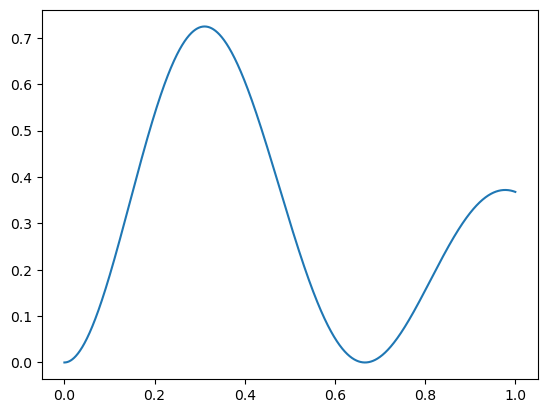

In [265]:
# initial condition (actually does not play a huge role here)
x = np.linspace(0, 1, Nx)
x0 = np.exp(-x)*np.sin(3*np.pi/2*x)**2
bd1 = x0[0]
bd2 = x0[-1]

plt.plot(x, x0)
plt.show()

### Добавим источники

In [266]:
# source location
s_pos = [0.12, 0.71]
s_val = [-0.42, -0.21]

### Решим задачу методом Ньютона

In [306]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources(s_pos, s_val)

In [307]:
nl_solver = newton(crit_abs=1e-8)
solver_n.setSolver(nl_solver)
solver_n.setInitial(x0)
X, mes, t_new, delta_new = test(solver_n, sample_size = 4)

test started
verdict : OK
time : 6.016 +- 0.2402
mean newton iterations:  6.8


In [269]:
print(solver_n.timelog.kn)

[11.  7.  6.  5.  5.]


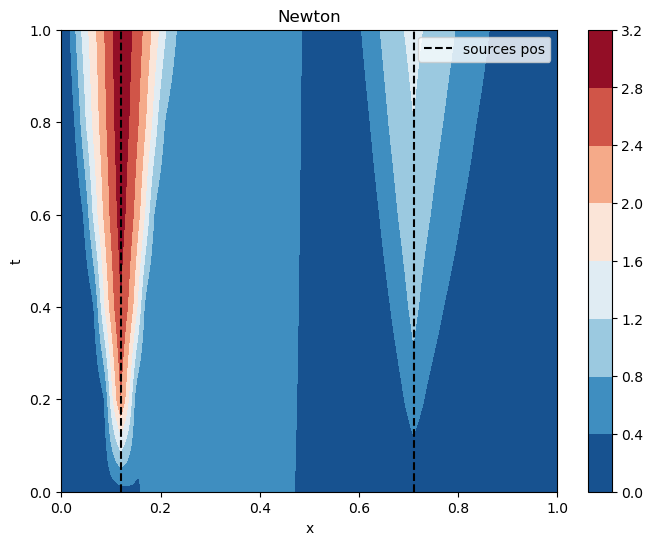

In [270]:
wp.show_res(solver_n)
plt.axvline(s_pos[0], linestyle='--', color= 'k', label='sources pos')
plt.axvline(s_pos[1], linestyle='--', color= 'k')
plt.legend()
plt.savefig(data_path + '1phase_prob1_newton', dpi= 400)
plt.show()

### Решим ту же задачу через ASPEN

In [271]:
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources(s_pos, s_val)
solver.setInitial(x0)

In [275]:
Nd = 4
partion = pt.partion_equally1D(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-8)
solver.setSolver(nl_solver)
X, mes, t_0, delta_0 = test(solver, sample_size=4)

test started
verdict : OK
time : 8.44 +- 0.1859
mean aspen iterations:  3.6


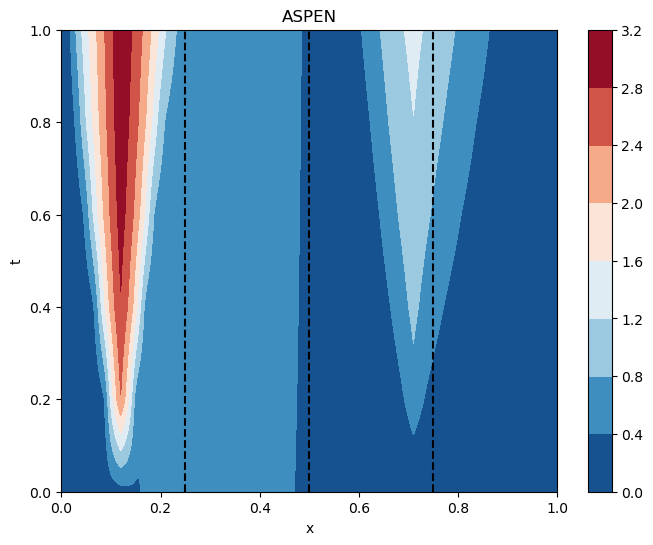

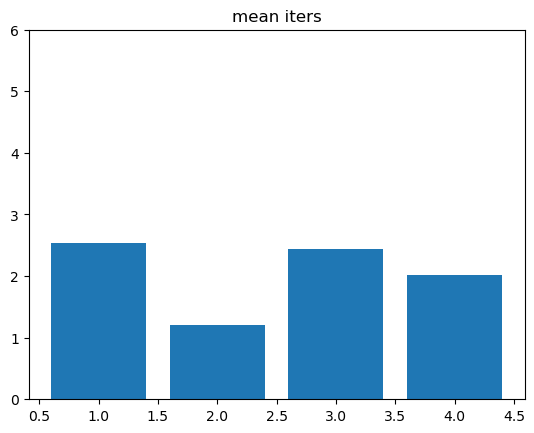

In [276]:
wp.show_res(solver, save='1phase_prob1_eq_ASPEN')
plt.show()
wp.bar_loc(solver, Nd, save='1phase_prob1_eq_mean_loc')
plt.show()

--time comparision--
newton : 6.705302953720093
aspen : 8.391188144683838


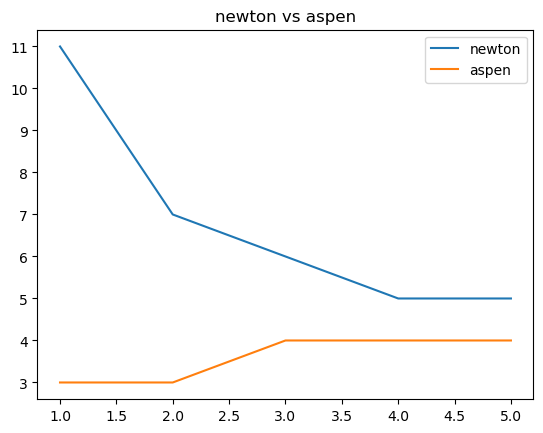

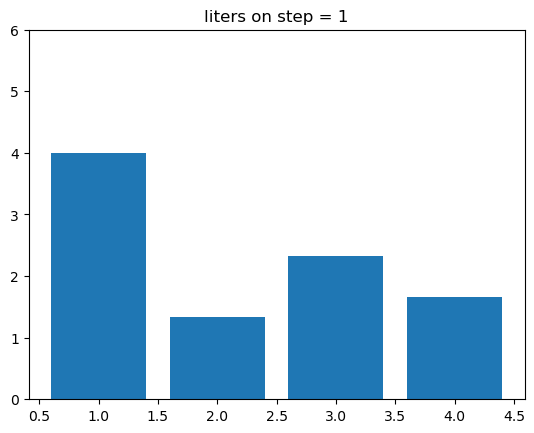

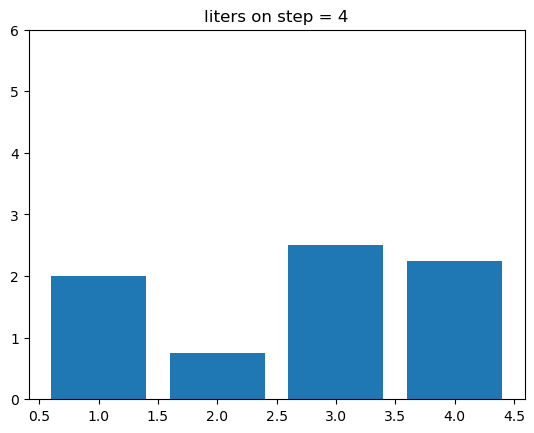

In [277]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp')
wp.bar_loc_step(solver, Nd, 1, save='1p1d_f_step=0')
wp.bar_loc_step(solver, Nd, 4, save='1p1d_f_step=5')

In [278]:
cost_eq = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
cost_new = solver_n.timelog.kn*Nx*(c_r+c_j+c_l)+c_r*Nx

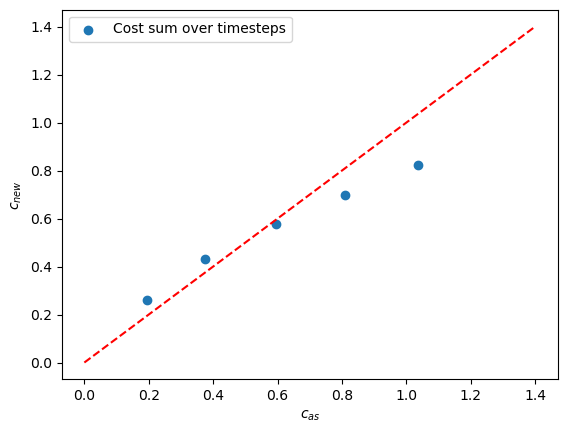

In [279]:
x_new = [np.sum(cost_new[:i]) for i in range(1, Nt+1)]
x_eq = [np.sum(cost_eq[:i]) for i in range(1, Nt+1)]

plt.scatter(x_eq, x_new, label='Cost sum over timesteps')
plt.plot([0, 1.4], [0, 1.4], linestyle='--', color='r')
plt.xlabel('$c_{as}$')
plt.ylabel('$c_{new}$')
plt.legend()
plt.savefig('./data/const_over_k_eq1', dpi = 300)
plt.show()

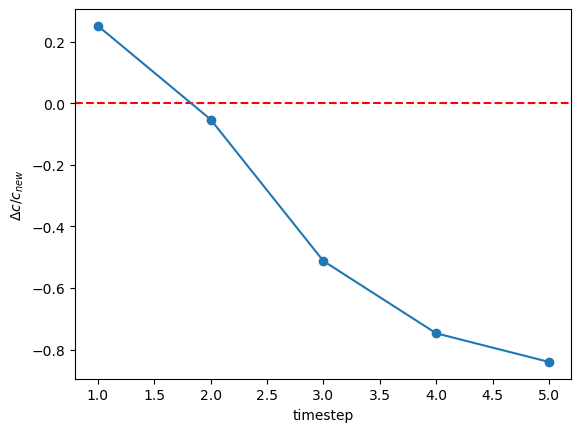

In [280]:
plt.axhline(0, linestyle = '--', color='r')
plt.plot(np.arange(Nt)+1, (cost_new-cost_eq)/cost_new, marker = 'o')
plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_otime_eq_1', dpi = 300)
plt.show()

#### Короткий вывод:
Почему мы проигрываем?
- Неправильно локализованные домены в начале, приводит к росту как глобальных, так и локальных иттераций
- Возможно, тербуется меньшее число доменов при "установлении" решения
- Возможно, мы тратим все еще слишком много иттераций на локлаьную стадию (т.е. 1-2 иттераций будет достаточно для некоторого "предобславливания")

#### Мини-план:
- Предложим какую-то одну подходящую модель разбиения на домены и для неё исследуем влияние неточного подхода к локальному решению
- Предложим новые модели разбиения на домены, отберем наиболее пригодную для них
- Для лучшей модели разбиения на домены исследуем влияние числа доменов

In [281]:
Nd = 4
partion = pt.partion_equally1D(Nx, Nd)
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources(s_pos, s_val)
solver.setInitial(x0)

In [283]:
time = np.zeros(10)
delta = np.zeros(10)
gb_iters = np.zeros((10, Nt))
lc_iters = np.zeros((10, Nd, Nt))
Cost_1 = np.zeros((10, Nt))

i = 0
for loc in np.logspace(-8, -6, 8):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-8, crit_loc = loc)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_1[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 8.704 +- 0.4485
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.412 +- 0.2014
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.222 +- 0.1315
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.247 +- 0.1748
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.198 +- 0.2177
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.475 +- 0.6343
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.202 +- 0.5167
mean aspen iterations:  3.6
test started
verdict : Not converged
time : 0.0 +- 0.0
mean aspen iterations:  0.0
7 Not converged


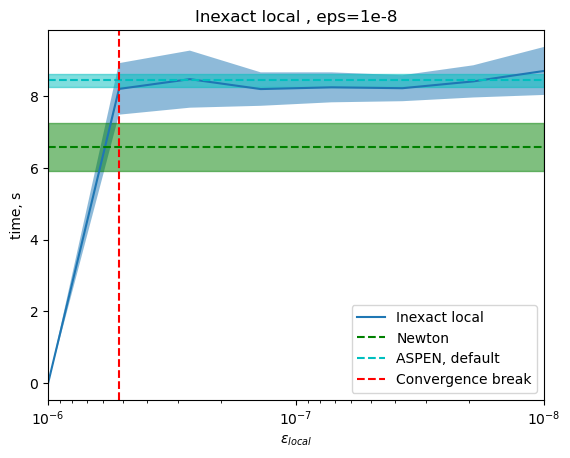

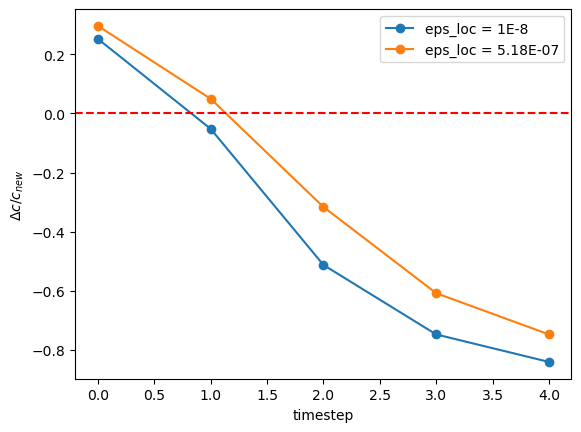

In [294]:
crit_loc = np.logspace(-8, -6, 8)

plt.title('Inexact local , eps=1e-8')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.plot(crit_loc[:], time[:-2], label='Inexact local')
plt.fill_between(crit_loc[:], time[:-2]+np.sqrt(delta[:-2]),
                time[:-2]-np.sqrt(delta[:-2]), alpha=0.5)
plt.axhline(t_new, color='g', linestyle='--', label='Newton')
plt.fill_between([1e-8,crit_loc[-1]], t_new+delta_new,
                t_new-delta_new, alpha=0.5, color ='g')
plt.axhline(t_0, color='c', linestyle='--', label='ASPEN, default')
plt.fill_between([1e-8,crit_loc[-1]], t_0+delta_0,
                t_0-delta_0, alpha=0.5, color ='c')
plt.axvline(crit_loc[-2] , linestyle='--', color='r', label='Convergence break')
plt.xlim([crit_loc[:][-1], 1e-8])
plt.legend()
plt.savefig('./data/Diff0_I_time1', dpi=400)
plt.show()

plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o', label = 'eps_loc = 1E-8')
plt.plot(np.arange(Nt), (cost_new-Cost_1[-4, :])/cost_new, marker='o',
         label ='eps_loc = {:.2E}'.format(np.logspace(-8, -6, 8)[-2]))
plt.axhline(0, linestyle='--', color='r')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_comp_over_time_eq1', dpi = 300)
plt.show()

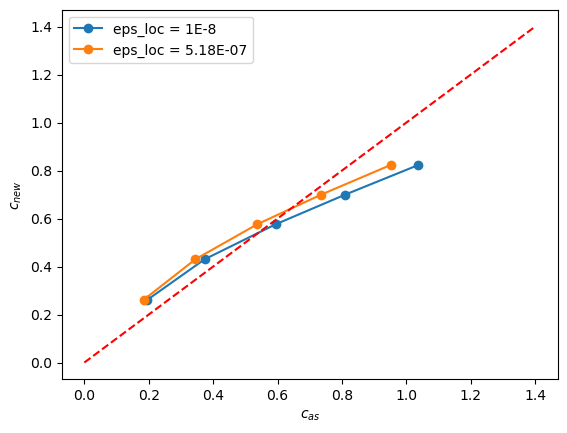

In [295]:
x_new = [np.sum(cost_new[:i]) for i in range(1, Nt+1)]
x_eq = [np.sum(cost_eq[:i]) for i in range(1, Nt+1)]
x_eq2 = [np.sum(Cost_1[6, :i]) for i in range(1, Nt+1)]

plt.plot(x_eq, x_new, marker='o', label = 'eps_loc = 1E-8')
plt.plot(x_eq2, x_new, marker='o',
         label ='eps_loc = {:.2E}'.format(np.logspace(-8, -6, 8)[-2]))
plt.plot([0, 1.4], [0, 1.4], linestyle='--', color='r')
plt.xlabel('$c_{as}$')
plt.ylabel('$c_{new}$')
plt.legend()
plt.savefig('./data/const_over_k_eq2', dpi = 300)
plt.show()

In [296]:
time = np.zeros(20)
delta = np.zeros(20)
gb_iters = np.zeros((20, Nt))
lc_iters = np.zeros((20, Nd, Nt))
Cost_2 = np.zeros((20, Nt))

i = 0
for crit_rel in np.logspace(-10, -1, 20):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-8, crit_rel = crit_rel)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_2[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 8.861 +- 0.3154
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.994 +- 0.5717
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.448 +- 0.2515
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.454 +- 0.2362
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.661 +- 0.7218
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.09 +- 0.5918
mean aspen iterations:  3.6
test started
verdict : OK
time : 7.876 +- 0.6002
mean aspen iterations:  3.6
test started
verdict : OK
time : 7.746 +- 0.5148
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.394 +- 0.6921
mean aspen iterations:  3.6
test started
verdict : OK
time : 8.07 +- 0.6151
mean aspen iterations:  3.6
test started
verdict : OK
time : 7.705 +- 0.2388
mean aspen iterations:  3.6
test started
verdict : OK
time : 7.58 +- 0.1574
mean aspen iterations:  3.6
test started
verdict : OK
time : 7.449 +- 0.1311
mean aspen iterations:  3.6
te

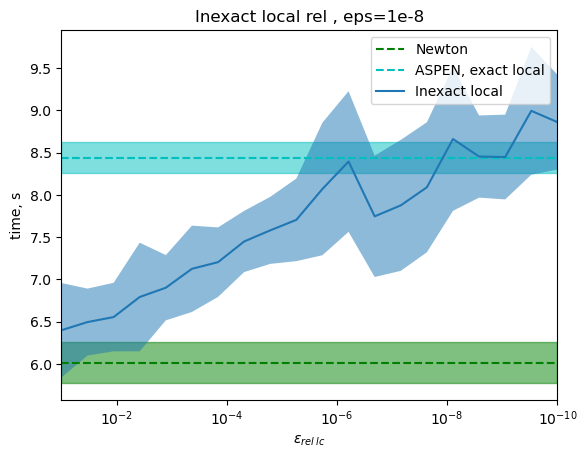

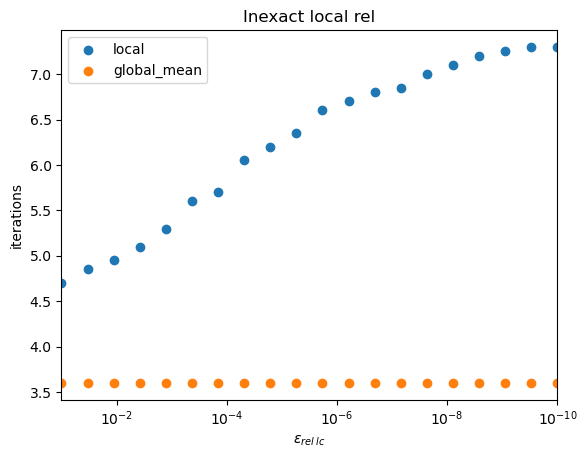

In [308]:
crit_rel = np.logspace(-10, -1, 20)

plt.title('Inexact local rel , eps=1e-8')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{rel \; lc}$')
plt.xscale('log')
plt.axhline(t_new, color='g', linestyle='--', label='Newton')
plt.fill_between(crit_rel, t_new+delta_new,
                t_new-delta_new, alpha=0.5, color ='g')
plt.axhline(t_0, color='c', linestyle='--', label='ASPEN, exact local')
plt.fill_between(crit_rel, t_0+delta_0,
                t_0-delta_0, alpha=0.5, color ='c')
plt.plot(crit_rel, time, label='Inexact local')
plt.fill_between(crit_rel, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.xlim([crit_rel[-1], crit_rel[0]])
plt.savefig('./data/rel0_Diff0_I_time2', dpi=400)
plt.legend()
plt.show()

plt.title('Inexact local rel')
plt.ylabel('iterations')
plt.xlabel(r'$\varepsilon_{rel \; lc}$')
plt.xscale('log')
plt.scatter(crit_rel, np.mean(np.mean(lc_iters, axis = 2), axis = 1), label='local')
plt.scatter(crit_rel, np.mean(gb_iters, axis = 1), label='global_mean')
plt.xlim([crit_rel[-1], crit_rel[0]])
plt.legend()
plt.savefig('./data/rel0_Diff0_I_lc_iters', dpi=400)
plt.show()

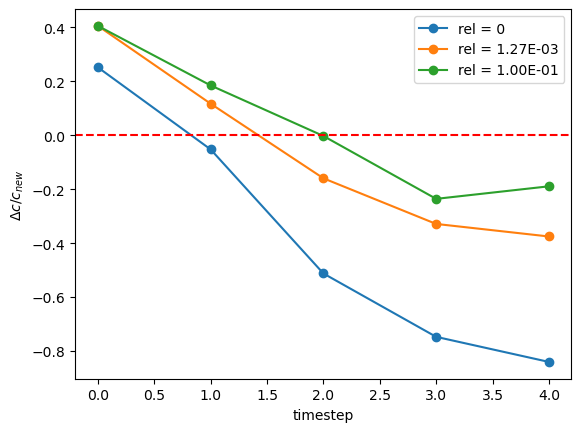

In [309]:
plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o', label = 'rel = 0')
plt.plot(np.arange(Nt), (cost_new-Cost_2[15, :])/cost_new, marker='o',
         label ='rel = {:.2E}'.format(np.logspace(-10, -1, 20)[15]))
plt.plot(np.arange(Nt), (cost_new-Cost_2[19, :])/cost_new, marker='o',
         label ='rel = {:.2E}'.format(np.logspace(-10, -1, 20)[19]))
plt.axhline(0, linestyle='--', color='r')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_comp_over_time_eq2', dpi = 300)
plt.show()

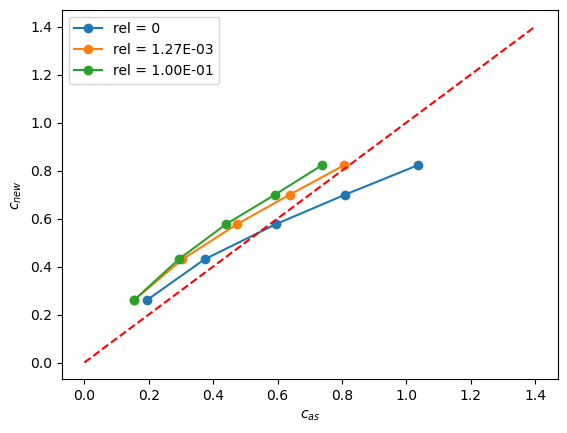

In [310]:
x_new = [np.sum(cost_new[:i]) for i in range(1, Nt+1)]
x_eq = [np.sum(cost_eq[:i]) for i in range(1, Nt+1)]
x_eq2 = [np.sum(Cost_2[15, :i]) for i in range(1, Nt+1)]
x_eq3 = [np.sum(Cost_2[19, :i]) for i in range(1, Nt+1)]

plt.plot(x_eq, x_new, marker='o', label = 'rel = 0')
plt.plot(x_eq2, x_new, marker='o',
         label ='rel = {:.2E}'.format(np.logspace(-10, -1, 20)[15]))
plt.plot(x_eq3, x_new, marker='o',
         label ='rel = {:.2E}'.format(np.logspace(-10, -1, 20)[19]))
plt.plot([0, 1.4], [0, 1.4], linestyle='--', color='r')
plt.xlabel('$c_{as}$')
plt.ylabel('$c_{new}$')
plt.legend()
plt.savefig('./data/const_over_k_eq_rel', dpi = 300)
plt.show()

### Модель разбиения на домены


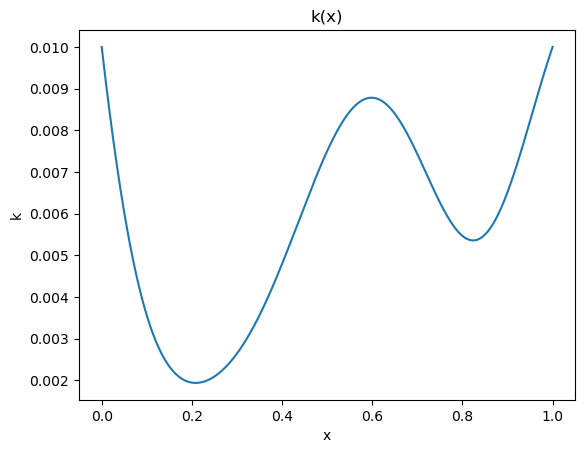

In [423]:
# generate some k(x) to test on latter
D = Diffusion(Nx, 0.9, 1, 2e-2, model=model)
D.gen_val(Nx, Amp = 0.5, Scale = 1e-2, k_sin = 3,  plot = True)
plt.savefig(data_path+'permeability dist, 1', dpi = 400)
plt.show()

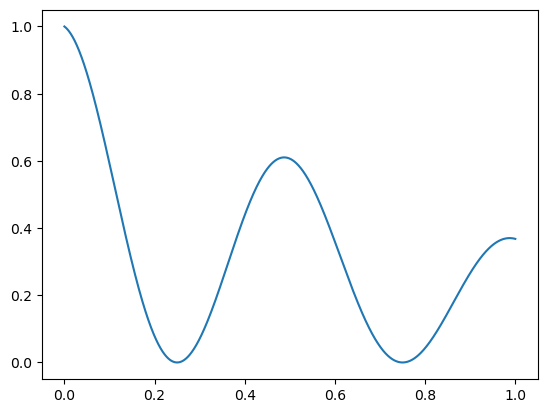

In [424]:
# initial condition (actually does not play a huge role here)
x = np.linspace(0, 1, Nx)
x0 = np.exp(-x)*np.cos(4*np.pi/2*x)**2
bd1 = x0[0]
bd2 = x0[-1]

plt.plot(x, x0)
plt.show()

test started
verdict : OK
time : 5.538 +- 0.4859
mean newton iterations:  5.2
[7. 5. 5. 5. 4.]


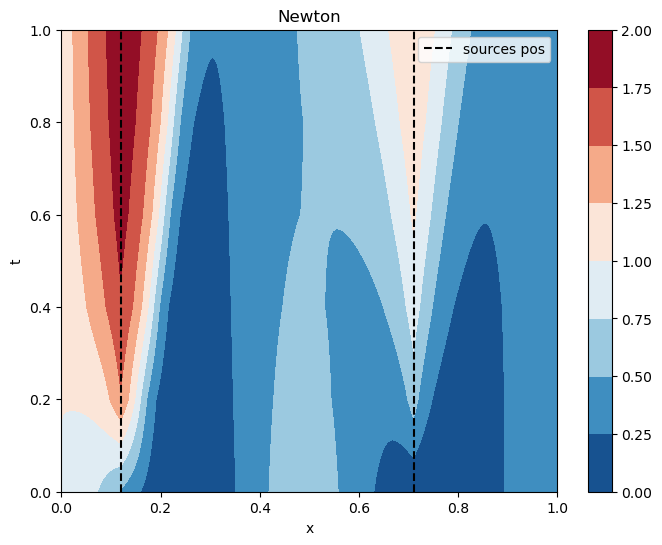

In [425]:
nl_solver = newton(crit_abs=1e-8)
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources(s_pos, s_val)
solver_n.setInitial(x0)
solver_n.setSolver(nl_solver)
X, mes, t_new, delta_new = test(solver_n, sample_size = 4)
wp.show_res(solver_n)
print(solver_n.timelog.kn)
plt.axvline(s_pos[0], linestyle='--', color= 'k', label='sources pos')
plt.axvline(s_pos[1], linestyle='--', color= 'k')
plt.legend()
plt.savefig(data_path + '1phase_prob2_newton', dpi= 400)
plt.show()

In [428]:
Nd = 4
Nx = 2000
Nt = 5
param ={'Nx': Nx, 'Nt' : Nt}
prob = one_phase(D, param)
partion = pt.partion_equally1D(Nx, Nd)
solver_eq = fxbd_1D(param, prob)
solver_eq.setBoundary(bd1, bd2)
solver_eq.setSources(s_pos, s_val)
solver_eq.setInitial(x0)
nl_solver = aspen(Nd, partion, crit_abs=1e-8, crit_rel = 1e-2)
solver_eq.setSolver(nl_solver)
X, mes, t_eq, delta_eq = test(solver_eq, sample_size=4)

test started
verdict : OK
time : 6.909 +- 0.4398
mean aspen iterations:  3.6


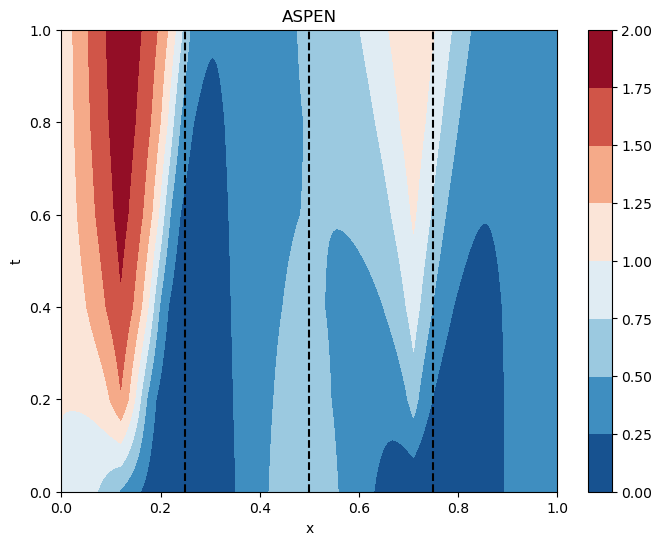

--time comparision--
newton : 5.933717250823975
aspen : 6.627796173095703


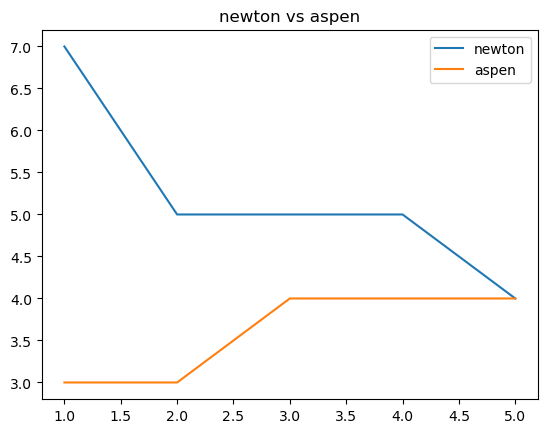

In [429]:
wp.show_res(solver_eq, save = 'one_phase_equally_1D_4')
plt.show()
cost_eq = Nx*( (c_r+c_l)*solver_eq.timelog.aspen_iters+c_r
    + np.mean(solver_eq.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
wp.compare([solver_n, solver_eq], ['newton', 'aspen'], save='comp, eq12')
plt.show()

### Модель через аналитику

In [430]:
from sklearn.cluster import KMeans

def border_changer_a(prob, X, nstep, Nd):
    x = np.linspace(0, 1, Nx//20).reshape(-1, 1)
    x_s = X[::20, nstep].flatten()
    k = (D.val[1::] + D.val[:-1:])[::20]/2
    q = np.zeros((Nx//20, 1))
    dt = 1/Nt
    x_front = np.sqrt(4*k*dt)
    for Pos, Val in zip(s_pos, s_val):
        index = round(100*Pos)
        q[index-1] = Val
        x_front[index] = Val*np.sqrt(k[index])*dt
        
    X_s = np.concatenate((x-x_front, x+x_front), axis = 1)
    
    kmeans = KMeans(n_clusters=Nd, random_state=0).fit(X_s, sample_weight = x_s)
    borders = [0]
    lb = kmeans.labels_
    j = 0
    flag = True
    for i in range(1, 100):
        if lb[i] != lb[i-1]:
            if j < Nd-1 or True:
                borders.append(i*20)
            j += 1
        if j > Nd-1 and flag:
            print('clustering alg returned more borders than declared, more domains should be considered')
            flag = False
    borders.append(Nx)
    domains = [np.arange(borders[i], borders[i+1]) for i in range(Nd)]
    return domains

In [431]:
prob = one_phase(D, param)
partion = border_changer_a(prob, x0.reshape(-1, 1), 0, Nd)
solver_a = fxbd_1D(param, prob)
solver_a.setBoundary(bd1, bd2)
solver_a.setSources(s_pos, s_val)
solver_a.setInitial(x0)
nl_solver = aspen(Nd, partion, crit_abs=1e-8, crit_rel = 1e-2)
solver_a.setSolver(nl_solver, bd_ch = border_changer_a)
X, mes, t, delta = test(solver_a, sample_size=4)

test started
verdict : OK
time : 6.233 +- 0.1635
mean aspen iterations:  3.4


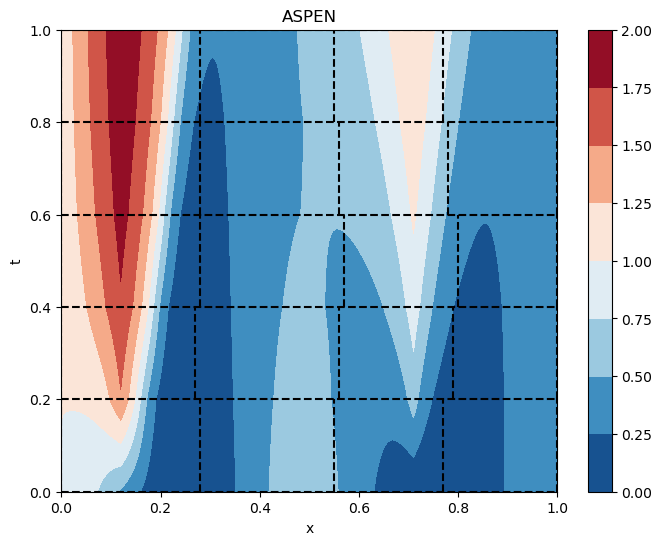

--time comparision--
newton : 5.933717250823975
aspen : 6.239625692367554


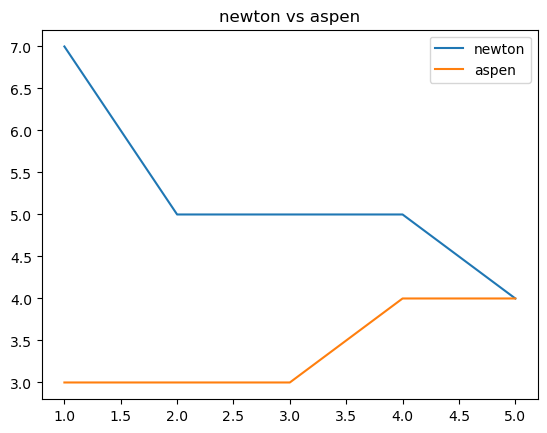

In [432]:
wp.show_res(solver_a, save = 'one_phase_analytical_1D_4')
plt.show()
wp.compare([solver_n, solver_a], ['newton', 'aspen'], save='comp, an12')
plt.show()

### Модель через Graph partioning problem

In [433]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 20)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m1(Jf, k, m)
    A1 = pt.adj_matrix(func1, Nx//20)
    #A1 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A1, Nd,
        inv = False, k =Nd)
    borders = borders * 20
    domains = [np.arange(borders[i], borders[i+1]) for i in range(Nd)]
    return domains
Nd = 4
prob = one_phase(D, param)
solver_m1 = fxbd_1D(param, prob)
solver_m1.setBoundary(bd1, bd2)
solver_m1.setSources(s_pos, s_val)
solver_m1.setInitial(x0)
partion = border_changer_a(prob, x0.reshape(-1, 1), 0, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-8, crit_rel = 1e-2)
solver_m1.setSolver(nl_solver, bd_ch = border_changer)
X, mes, t, delta = test(solver_m1, sample_size=4)

test started
verdict : OK
time : 6.407 +- 0.2038
mean aspen iterations:  3.4


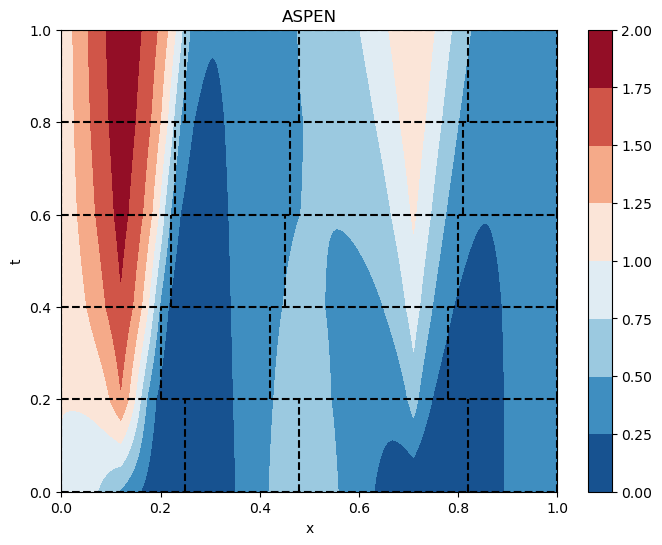

--time comparision--
newton : 5.933717250823975
aspen : 6.443942546844482


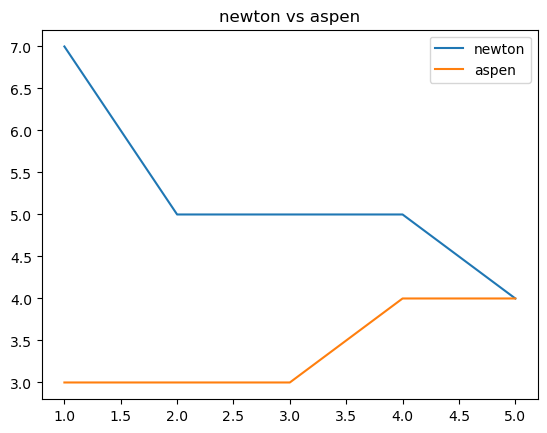

In [434]:
wp.show_res(solver_m1, save = 'one_phase_analytical_1D_m1')
plt.show()
wp.compare([solver_n, solver_m1], ['newton', 'aspen'], save='comp, m12')
plt.show()

In [435]:
def border_changer(prob, X, nstep, Nd):
    func1 = lambda k, m: m2(X[:, :nstep+1], k, m, x_step = 20)
    #func1 = lambda k, m: m2(X, k, m)
    A2 = pt.adj_matrix(func1, Nx//20)
    #A2 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A2, Nd,
        inv = True, k =Nd)
    borders = borders * 20
    domains = [np.arange(borders[i], borders[i+1]) for i in range(Nd)]
    return domains
Nd = 4
prob = one_phase(D, param)
solver_m2 = fxbd_1D(param, prob)
solver_m2.setBoundary(bd1, bd2)
solver_m2.setSources(s_pos, s_val)
solver_m2.setInitial(x0)
partion = border_changer_a(prob, x0.reshape(-1, 1), 0, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-8, crit_rel = 1e-2)
solver_m2.setSolver(nl_solver, bd_ch = border_changer)
X, mes, t, delta = test(solver_m2, sample_size=4)

test started
verdict : OK
time : 6.722 +- 0.1852
mean aspen iterations:  3.6


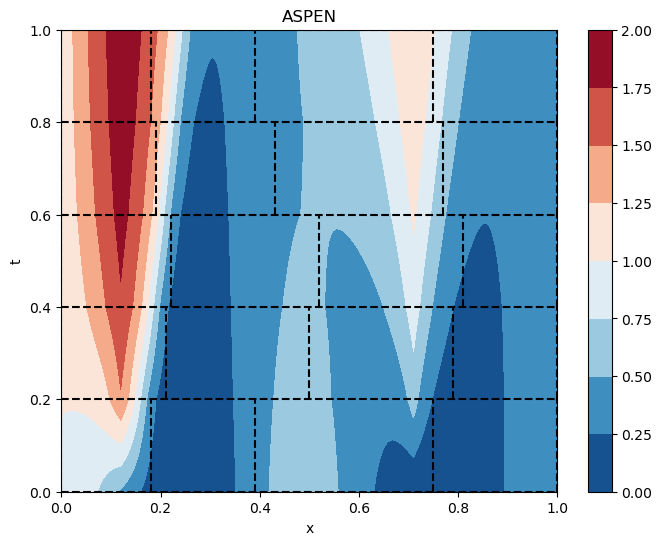

--time comparision--
newton : 5.933717250823975
aspen : 6.718325138092041


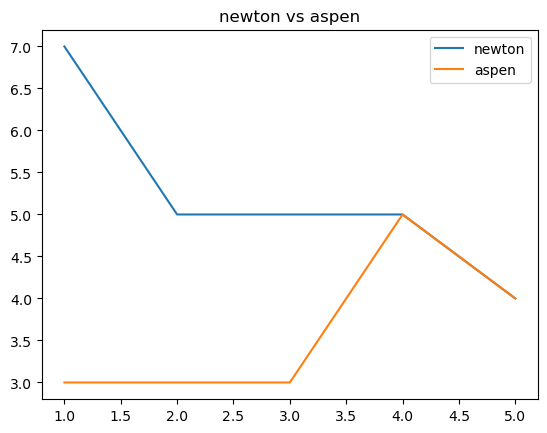

In [436]:
wp.show_res(solver_m2, save = 'one_phase_analytical_1D_m2')
plt.show()
wp.compare([solver_n, solver_m2], ['newton', 'aspen'], save='comp, 22')
plt.show()

In [437]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 20)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 5, step = 20)
    #func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10)
    A3 = pt.adj_matrix(func1, Nx//20);
    #A3 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A3, Nd,
        inv = False, k =Nd)
    borders = borders * 20
    domains = [np.arange(borders[i], borders[i+1]) for i in range(Nd)]
    return domains
Nd = 4
prob = one_phase(D, param)
solver_m3 = fxbd_1D(param, prob)
solver_m3.setBoundary(bd1, bd2)
solver_m3.setSources(s_pos, s_val)
solver_m3.setInitial(x0)
partion = border_changer_a(prob, x0.reshape(-1, 1), 0, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-8, crit_rel = 1e-2)
solver_m3.setSolver(nl_solver, bd_ch = border_changer)
X, mes, t, delta = test(solver_m3, sample_size=4)

test started
verdict : OK
time : 5.734 +- 0.1902
mean aspen iterations:  2.8


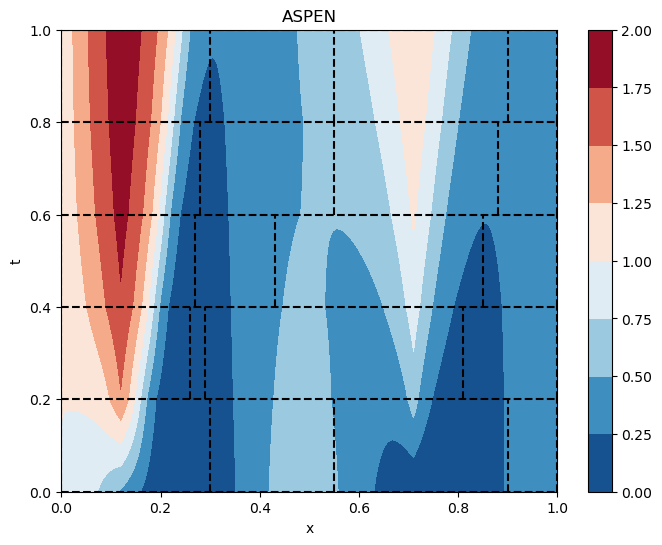

--time comparision--
newton : 5.933717250823975
aspen : 5.752111911773682


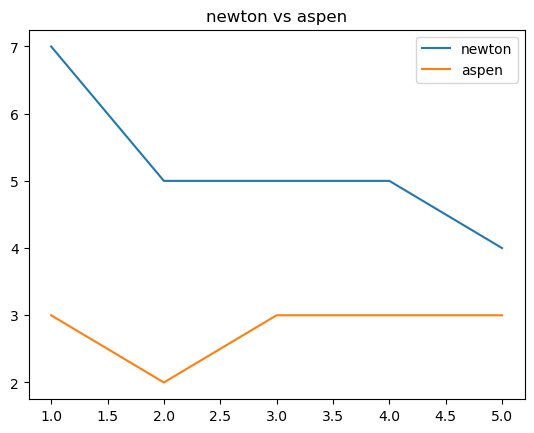

In [438]:
wp.show_res(solver_m3, save = 'one_phase_analytical_1D_m3')
plt.show()
wp.compare([solver_n, solver_m3], ['newton', 'aspen'], save='comp, 23')
plt.show()

In [450]:
cost_new = solver_n.timelog.kn*Nx*(c_r+c_j+c_l)+c_r*Nx

cost_a = Nx*( (c_r+c_l)*solver_a.timelog.aspen_iters[:]+c_r) \
    + (c_r+c_l+c_j) * \
        np.sum((solver_a.timelog.borders[1:, :]-solver_a.timelog.borders[:-1, :])*\
        solver_a.timelog.domain_iters[:, :], axis = 0)
cost_m1 = Nx*( (c_r+c_l)*solver_m1.timelog.aspen_iters[:]+c_r) \
    + (c_r+c_l+c_j) * \
        np.sum((solver_m1.timelog.borders[1:, :]-solver_m1.timelog.borders[:-1, :])*\
        solver_m1.timelog.domain_iters[:, :], axis = 0)
cost_m2 = Nx*( (c_r+c_l)*solver_m2.timelog.aspen_iters[:]+c_r) \
    + (c_r+c_l+c_j) * \
        np.sum((solver_m2.timelog.borders[1:, :]-solver_m2.timelog.borders[:-1, :])*\
        solver_m2.timelog.domain_iters[:, :], axis = 0)
cost_m3 = Nx*( (c_r+c_l)*solver_m3.timelog.aspen_iters[:]+c_r) \
    + (c_r+c_l+c_j) * \
        np.sum((solver_m3.timelog.borders[1:, :]-solver_m3.timelog.borders[:-1, :])*\
        solver_m3.timelog.domain_iters[:, :], axis = 0)

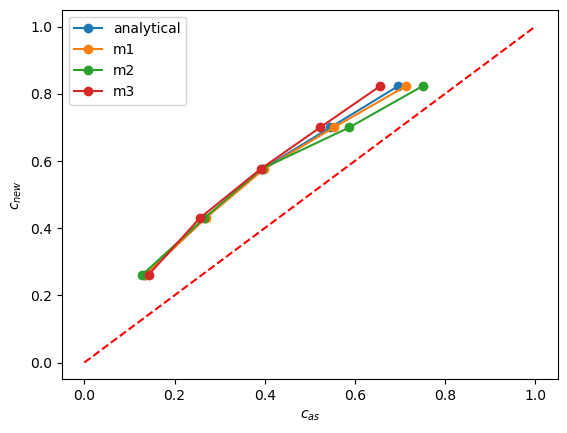

In [455]:
x_n = [np.sum(cost_new[:i]) for i in range(1, Nt+1)]
x_eq = [np.sum(cost_eq[:i]) for i in range(1, Nt+1)]
x_a = [np.sum(cost_a[:i]) for i in range(1, Nt+1)]

x_1 = [np.sum(cost_m1[:i]) for i in range(1, Nt+1)]
x_2 = [np.sum(cost_m2[:i]) for i in range(1, Nt+1)]
x_3 = [np.sum(cost_m3[:i]) for i in range(1, Nt+1)]


#plt.plot(x_eq, x_new, marker='o', label = 'equal')
plt.plot(x_a, x_new, marker='o', label = 'analytical')

plt.plot(x_1, x_new, marker='o', label = 'm1')
plt.plot(x_2, x_new, marker='o', label = 'm2')
plt.plot(x_3, x_new, marker='o', label = 'm3')

plt.plot([0, 1.0], [0, 1.0], linestyle='--', color='r')
plt.xlabel('$c_{as}$')
plt.ylabel('$c_{new}$')
plt.legend()
plt.savefig('./data/const_over_k_eq_rel123', dpi = 300)
plt.show()

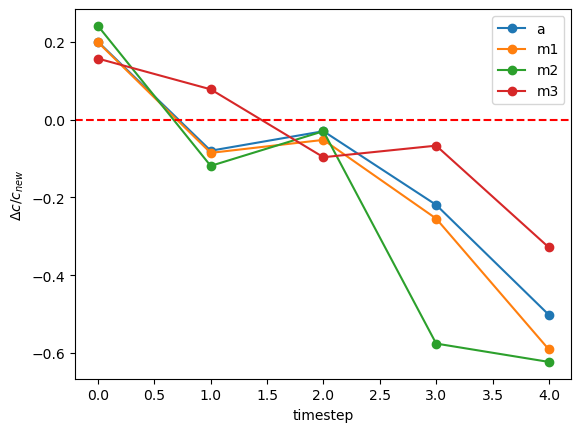

In [457]:
plt.plot(np.arange(Nt), (cost_new-cost_a)/cost_new, marker='o', label='a')
plt.plot(np.arange(Nt), (cost_new-cost_m1)/cost_new, marker='o', label='m1')
plt.plot(np.arange(Nt), (cost_new-cost_m2)/cost_new, marker='o', label='m2')
plt.plot(np.arange(Nt), (cost_new-cost_m3)/cost_new, marker='o', label='m3')
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.legend()
plt.savefig('./data/metrics_comp_over_time', dpi = 300)
plt.show()

### Задача о выборе оптимального числа доменов

In [463]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 20)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 5, step = 20)
    #func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10)
    A3 = pt.adj_matrix(func1, Nx//20);
    #A3 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A3, Nd,
        inv = False, k =Nd)
    borders = borders * 20
    domains = [np.arange(borders[i], borders[i+1]) for i in range(Nd)]
    return domains

time = np.zeros(5)
delta = np.zeros(5)
gb_iters = np.zeros((5, Nt))
cost_2 = np.zeros((5, Nt))

for i in range(5):
    Nd = 2+i
    prob = one_phase(D, param)
    solver_m3 = fxbd_1D(param, prob)
    solver_m3.setBoundary(bd1, bd2)
    solver_m3.setSources(s_pos, s_val)
    prob.setBcSr(solver_m3.bc, solver_m3.q)
    solver_m3.setInitial(x0)
    partion = border_changer_a(prob, x0.reshape(-1, 1), 0, Nd)
    nl_solver = aspen(Nd, partion, crit_abs=1e-8, crit_rel = 1e-2)
    solver_m3.setSolver(nl_solver, bd_ch = border_changer)
    print('num =', Nd);
    _, _, t, dt = test(solver_m3, sample_size=4)
    time[i] = t
    delta[i] = dt
    gb_iters[i, :] = solver_m3.timelog.aspen_iters
    
    cost_2[i, :] = Nx*( (c_r+c_l)*solver_m3.timelog.aspen_iters[:]+c_r) \
    + (c_r+c_l+c_j) * \
        np.sum((solver_m3.timelog.borders[1:, :]-solver_m3.timelog.borders[:-1, :])*\
        solver_m3.timelog.domain_iters[:, :], axis = 0)

/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


num = 2
test started
verdict : OK
time : 5.926 +- 0.4858
mean aspen iterations:  2.6
num = 3
test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


verdict : OK
time : 5.915 +- 0.2545
mean aspen iterations:  2.8
num = 4
test started
verdict : OK
time : 5.568 +- 0.2444
mean aspen iterations:  2.8
num = 5
test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


verdict : OK
time : 5.746 +- 0.5708
mean aspen iterations:  3.0
num = 6
test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


verdict : OK
time : 6.103 +- 0.2449
mean aspen iterations:  3.6


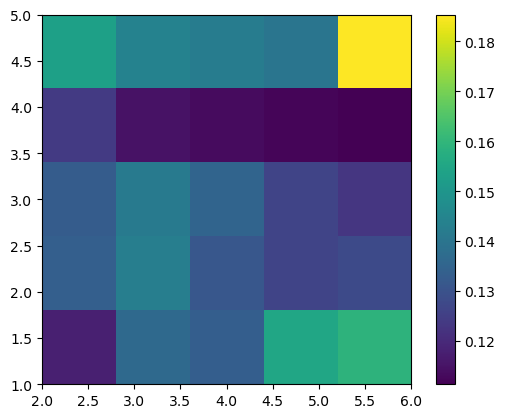

In [485]:
x = np.arange(2, 7)
y = np.arange(1, 6)
extent = np.min(x), np.max(x), np.min(y), np.max(y)
plt.imshow(cost_2.T, extent = extent)

plt.colorbar()